# 1.Loading JSON dataset

In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word
import pandas as pd 
import numpy as np 
import math
import nltk
import json
import os
import re

def read_truth(path):
    data = []
    index = []
    for i, line in enumerate(open(path + '/truth.jsonl', 'r')):
        instance = json.loads(line)
        data.append(instance)
        index.append(instance['id'])
    df = pd.DataFrame(data=data, index=index)
    df.sort_index(inplace=True)
    return df

def read_instance(path):
    data = []
    index = []
    for i, line in enumerate(open(path + '/instances.jsonl', 'rb')):
        instance = json.loads(line)
        data.append(instance)
        index.append(instance['id'])
    df = pd.DataFrame(data=data, index=index)
    df.sort_index(inplace=True)
    return df


train_truth = read_truth('./clickbait17-train-170331')
train_instances = read_instance('./clickbait17-train-170331')
validation_truth = read_truth('./clickbait17-validation-170630')
validation_instances = read_instance('./clickbait17-validation-170630')
train = pd.merge(train_truth, train_instances, on = 'id')
validation = pd.merge(validation_truth, validation_instances, on = 'id')
data = pd.concat([train, validation],ignore_index = True)
data['truthClass'] = data['truthClass'].map({'clickbait':True ,'no-clickbait':False}).astype(bool)

D:\Anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# 2.Pre-processing

In [2]:
import os
import re
import warnings
warnings.simplefilter( "ignore", UserWarning)
from matplotlib import pyplot as plt
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from string import punctuation
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score , auc , roc_auc_score
from sklearn.externals import joblib
import scipy
from scipy.sparse import hstack
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Embedding, GRU
from keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit
from keras import metrics
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
en_corpus = stopwords.words('english')
stop_words = []
caption = []
content = []
title = []

for sentence in data['targetParagraphs']:
    sentence = str(sentence).replace('[^\w\s]','')
    sentence = re.sub('[\u0060|\u0021-\u002c|\u002e-\u002f|\u003a-\u003f|\u2200-\u22ff|\uFB00-\uFFFD|\u2E80-\u33FF]',' ',sentence)
    sentence = re.sub( r'httpS+', '', sentence)
    sentence = re.sub( r"#(w+)", '', sentence)
    sentence = re.sub( r"@(w+)", '', sentence)
    stop_cnt = 0
    string = ''
#     sentence = TextBlob(sentence).correct()
    for word in sentence.split():
        if word in en_corpus:
            stop_cnt += 1
        if word not in en_corpus:            
            string += ' ' + word.lower()
    stop_words.append(stop_cnt)
    content.append(string)    

for sentence in data['targetCaptions']:
    string = ''
    sentence = str(sentence).replace('[^\w\s]','')
    sentence = re.sub('[\u0060|\u0021-\u002c|\u002e-\u002f|\u003a-\u003f|\u2200-\u22ff|\uFB00-\uFFFD|\u2E80-\u33FF]',' ',sentence)
    sentence = re.sub( r'httpS+', '', sentence)
    sentence = re.sub( r"#(w+)", '', sentence)
    sentence = re.sub( r"@(w+)", '', sentence)
    for word in sentence.split():
        if word not in en_corpus:            
            string += ' ' + word.lower()
    caption.append(string) 

for sentence in data['targetTitle']:
    string = ''
    sentence = str(sentence).replace('[^\w\s]','')
    sentence = re.sub('[\u0060|\u0021-\u002c|\u002e-\u002f|\u003a-\u003f|\u2200-\u22ff|\uFB00-\uFFFD|\u2E80-\u33FF]',' ',sentence)
    sentence = re.sub( r'httpS+', '', sentence)
    sentence = re.sub( r"#(w+)", '', sentence)
    sentence = re.sub( r"@(w+)", '', sentence)
    for word in sentence.split():
        if word not in en_corpus:            
            string += ' ' + word.lower()
    title.append(string)
    
corpus = title + content + caption


target_caption = []
target_content = []
target_title = []

common = pd.Series(' '.join(caption).split()).value_counts()[:10]
rare = pd.Series(' '.join(caption).split()).value_counts()[-10:]  

for sentence in caption:
    string = ''
    lemma = ''
    sentence = str(sentence)
    for word in sentence.split():
        if word not in common:
            if word  not in rare:
                lemma = Word(word).lemmatize()
                string += ' ' + lemma
    target_caption.append(string)

common = pd.Series(' '.join(content).split()).value_counts()[:10]
rare = pd.Series(' '.join(content).split()).value_counts()[-10:]  

for sentence in content:
    string = ''
    sentence = str(sentence)
    for word in sentence.split():
        if word not in common:
            if word  not in rare:
                lemma = Word(word).lemmatize()
                string += ' ' + lemma
    target_content.append(string)
    
common = pd.Series(' '.join(title).split()).value_counts()[:10]
rare = pd.Series(' '.join(title).split()).value_counts()[-10:]  

for sentence in title:
    string = ''
    sentence = str(sentence)
    for word in sentence.split():
        if word not in common:
            if word  not in rare:
                lemma = Word(word).lemmatize()
                string += ' ' + lemma
    target_title.append(string) 
    
target_corpus = []
for i in range(len(target_content)):
    total_context = target_caption[i] + target_content[i] + target_title[i]
    total_context = str(total_context).replace('[','').replace(']','').replace('\\','')
    target_corpus.append(total_context)

# 3.Word Embeddings

In [4]:
glove_input_file = 'glove.840B.300d.txt'
word2vec_output_file = 'glove.840B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)
filename = 'glove.840B.300d.txt.word2vec'
w2v_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [5]:
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.15
TEST_SPLIT = 0.15

In [6]:
label = []
for score in data['truthMean']:
    if score >= 0.5:
        label.append(1)
    else:
        label.append(0)

In [7]:
label = np.array(label)
label = to_categorical(np.asarray(label))
print('Shape of label tensor:', label.shape)

Shape of label tensor: (21997, 2)


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(target_corpus)
sequences = tokenizer.texts_to_sequences(target_corpus)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
pad_seq = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', pad_seq.shape)
print('Shape of label tensor:', label.shape)

Found 215911 unique tokens.
Shape of data tensor: (21997, 100)
Shape of label tensor: (21997, 2)


In [9]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
not_in_model = 0
in_model = 0
for word, i in word_index.items():
    if word in w2v_model:
        in_model += 1
        embedding_matrix[i] = np.asarray(w2v_model[word], dtype='float32')
    else:
        not_in_model += 1
print (str(not_in_model)+' words not in w2v model\n')
print (str(in_model)+' words in w2v model')

128628 words not in w2v model

87283 words in w2v model


In [10]:
p1 = int(len(pad_seq)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(pad_seq)*(1-TEST_SPLIT))
x_train = pad_seq[:p1]
y_train = label[:p1]
x_val = pad_seq[p1:p2]
y_val = label[p1:p2]
x_test = pad_seq[p2:]
y_test = label[p2:]
print ('train docs: '+str(len(x_train)))
print ('val docs: '+str(len(x_val)))
print ('test docs: '+str(len(x_test)))

train docs: 15397
val docs: 3300
test docs: 3300


In [11]:
gt_test = []
for score in data['truthMean'][p2:]:
    if score >= 0.5:
        gt_test.append(1)
    else:
        gt_test.append(0)

gt_test = np.array(gt_test)

# 4.Model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          64773600  
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               164736    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 64,938,594
Trainable params: 164,994
Non-trainable params: 64,773,600
_________________________________________________________________
['loss', 'acc']
Instructions for updating:
Use tf.cast instead.
Train

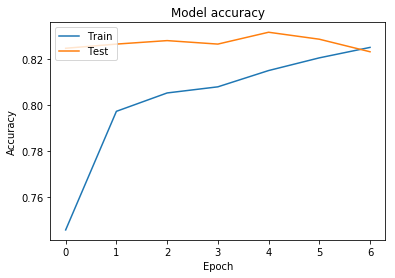

3300/3300 [==============================] - 2s 553us/step
[2.2349970332781472, 0.8224242424242424]


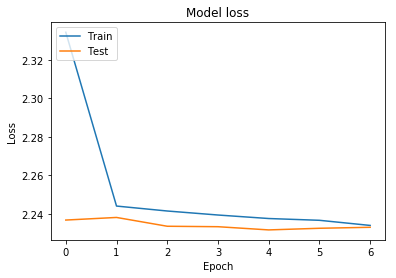

             precision    recall  f1-score   support

          0       0.86      0.91      0.89      2520
          1       0.65      0.54      0.59       780

avg / total       0.81      0.82      0.82      3300

[[2292  228]
 [ 358  422]]


In [12]:
from sklearn import metrics
from keras import regularizers
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)
model = Sequential()
model.add(embedding_layer)
model.add(GRU(128, dropout=0.3, recurrent_dropout=0.3))
model.add(Dropout(0.1))
model.add(Dense(label.shape[1], activation='softmax',
                kernel_regularizer=regularizers.l2(0.1),
                activity_regularizer=regularizers.l2(0.1)))
model.summary() 
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])
print (model.metrics_names)
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=7, batch_size=32)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
print (model.evaluate(x_test, y_test))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
train_predictions = model.predict_classes(x_test)
print(metrics.classification_report(gt_test, train_predictions)) 
print(confusion_matrix(gt_test, train_predictions))